In [1]:
%load_ext autoreload
%autoreload all

import torch

from gem import DFC2022Dataset, DFC2022DataModule

torch.cuda.empty_cache()
dir_path = '/GEM/data/MiniFrance/'
datamodule = DFC2022DataModule(dir_path, patch_size=512, batch_size=6, num_workers=6)

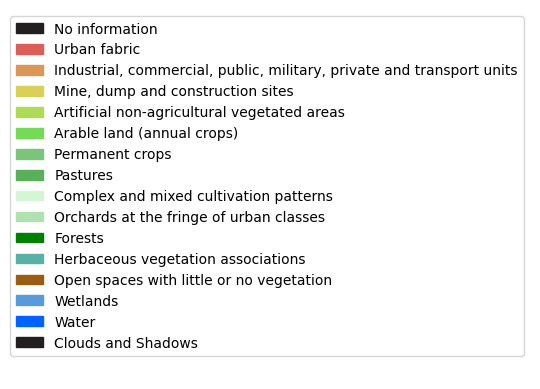

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

handles = [Patch(color=c, label=l) for l, c in zip(DFC2022Dataset.classes, DFC2022Dataset.colormap)]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [3]:

import lightning as pl
import os

from gem import EarthMapping

os.chdir('/GEM')
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
MAX_EPOCHS = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = datamodule.dataset.calc_class_weights().to(device)
print({name: weight.item() for name, weight in zip(DFC2022Dataset.classes, class_weights)})
model = EarthMapping()

accelerator = 'gpu' if device.type == 'cuda' else 'cpu'
trainer = pl.Trainer(enable_progress_bar=True, accelerator='gpu', devices=1, max_epochs=MAX_EPOCHS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'No information': 0.0, 'Urban fabric': 11.941902160644531, 'Industrial, commercial, public, military, private and transport units': 19.064714431762695, 'Mine, dump and construction sites': 232.92881774902344, 'Artificial non-agricultural vegetated areas': 97.26484680175781, 'Arable land (annual crops)': 9.989909172058105, 'Permanent crops': 59.344722747802734, 'Pastures': 3.4119253158569336, 'Complex and mixed cultivation patterns': 0.0, 'Orchards at the fringe of urban classes': 0.0, 'Forests': 4.301761150360107, 'Herbaceous vegetation associations': 10.77350902557373, 'Open spaces with little or no vegetation': 44.760738372802734, 'Wetlands': 38.26409149169922, 'Water': 82.41312408447266, 'Clouds and Shadows': 0.0}


In [ ]:
trainer.fit(model, datamodule)

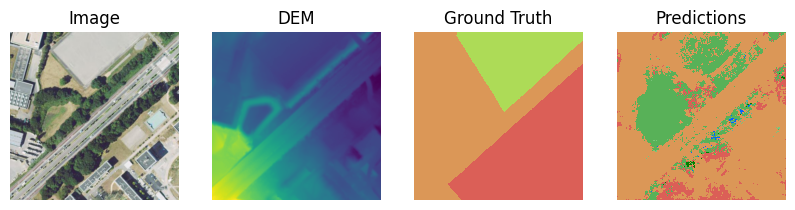

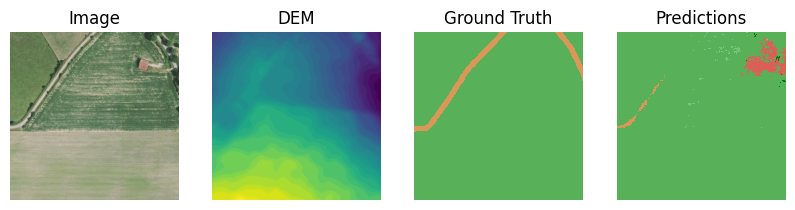

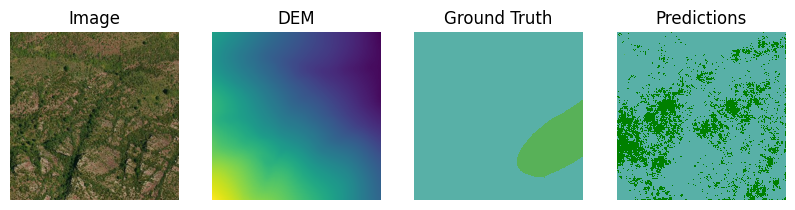

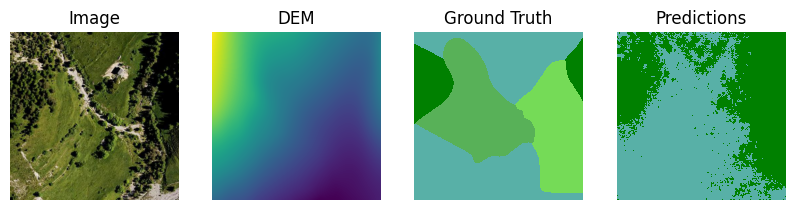

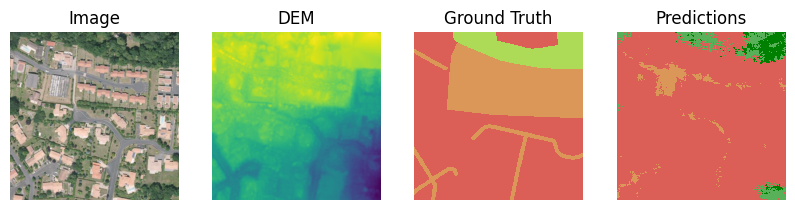

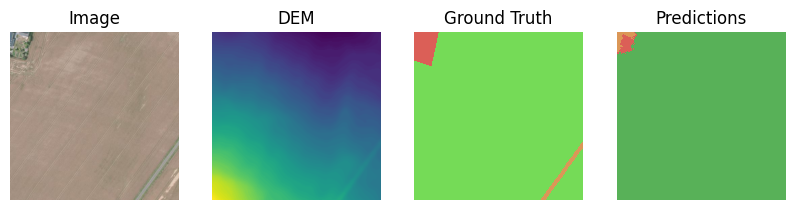

In [5]:
import torch
from gem.dataset import plot_batch

datamodule.setup()
val_iter = iter(datamodule.val_dataloader())
val_batches = [next(val_iter) for _ in range(6)]

# model = EarthMapping.load_from_checkpoint('/GEM/lightning_logs/version_26/checkpoints/epoch=69-step=70.ckpt')
# model = model.cpu()
model.eval()
with torch.no_grad():
    for batch in val_batches:
        preds = model(batch)
        plot_batch(batch, preds, datamodule.dataset)